# Data Analytics Project - Models

# Pair 3 - TATAMOTORS ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 3 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

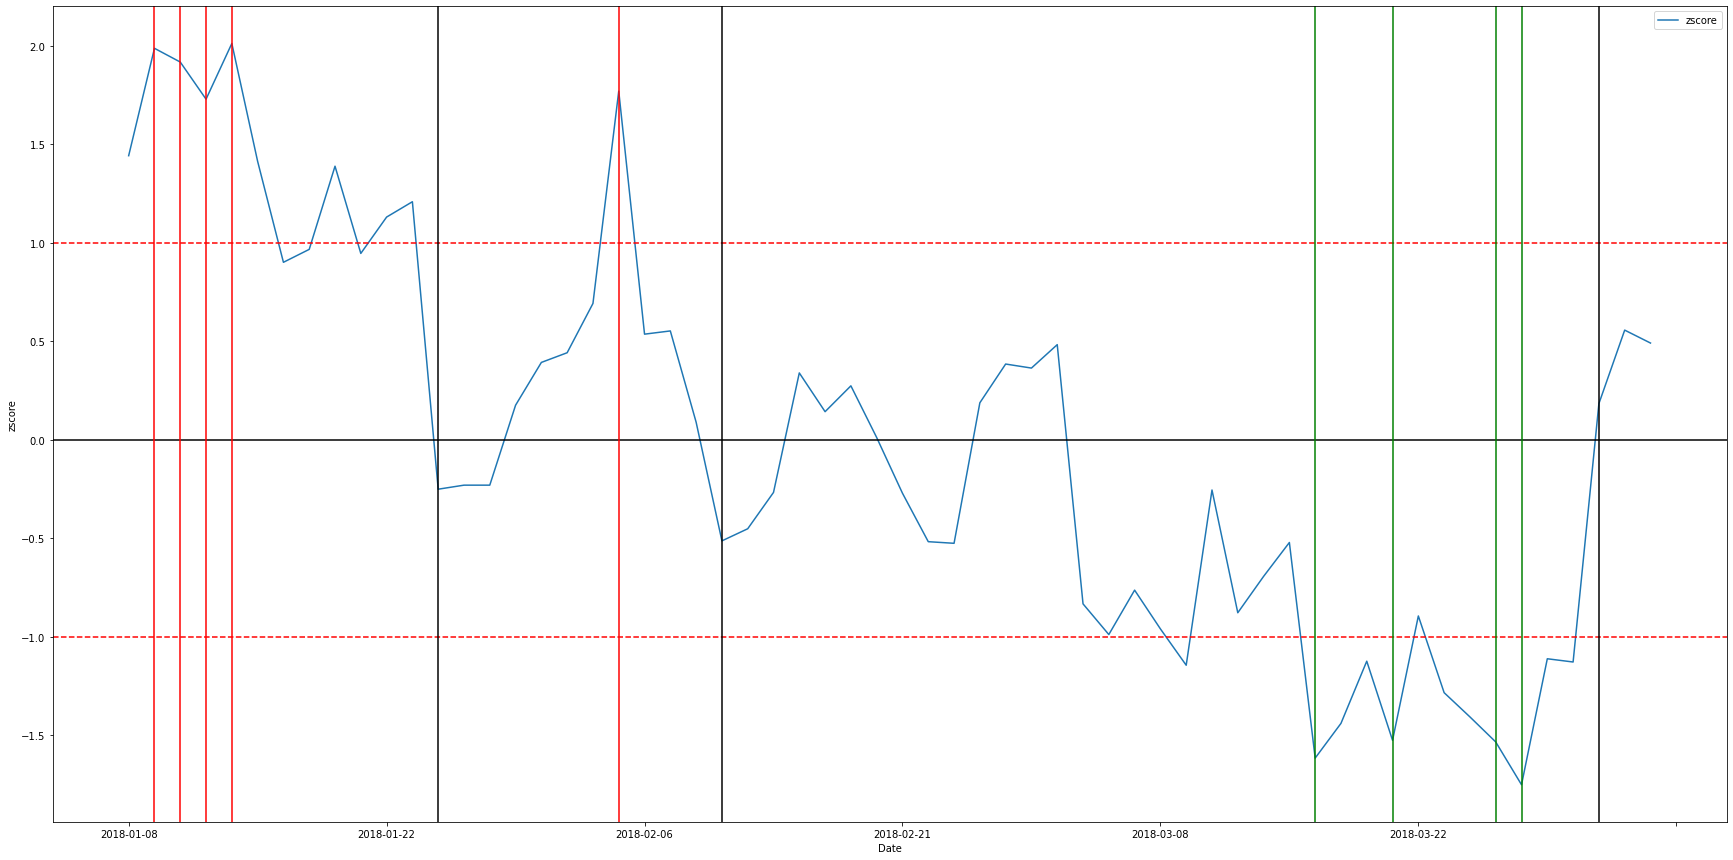

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

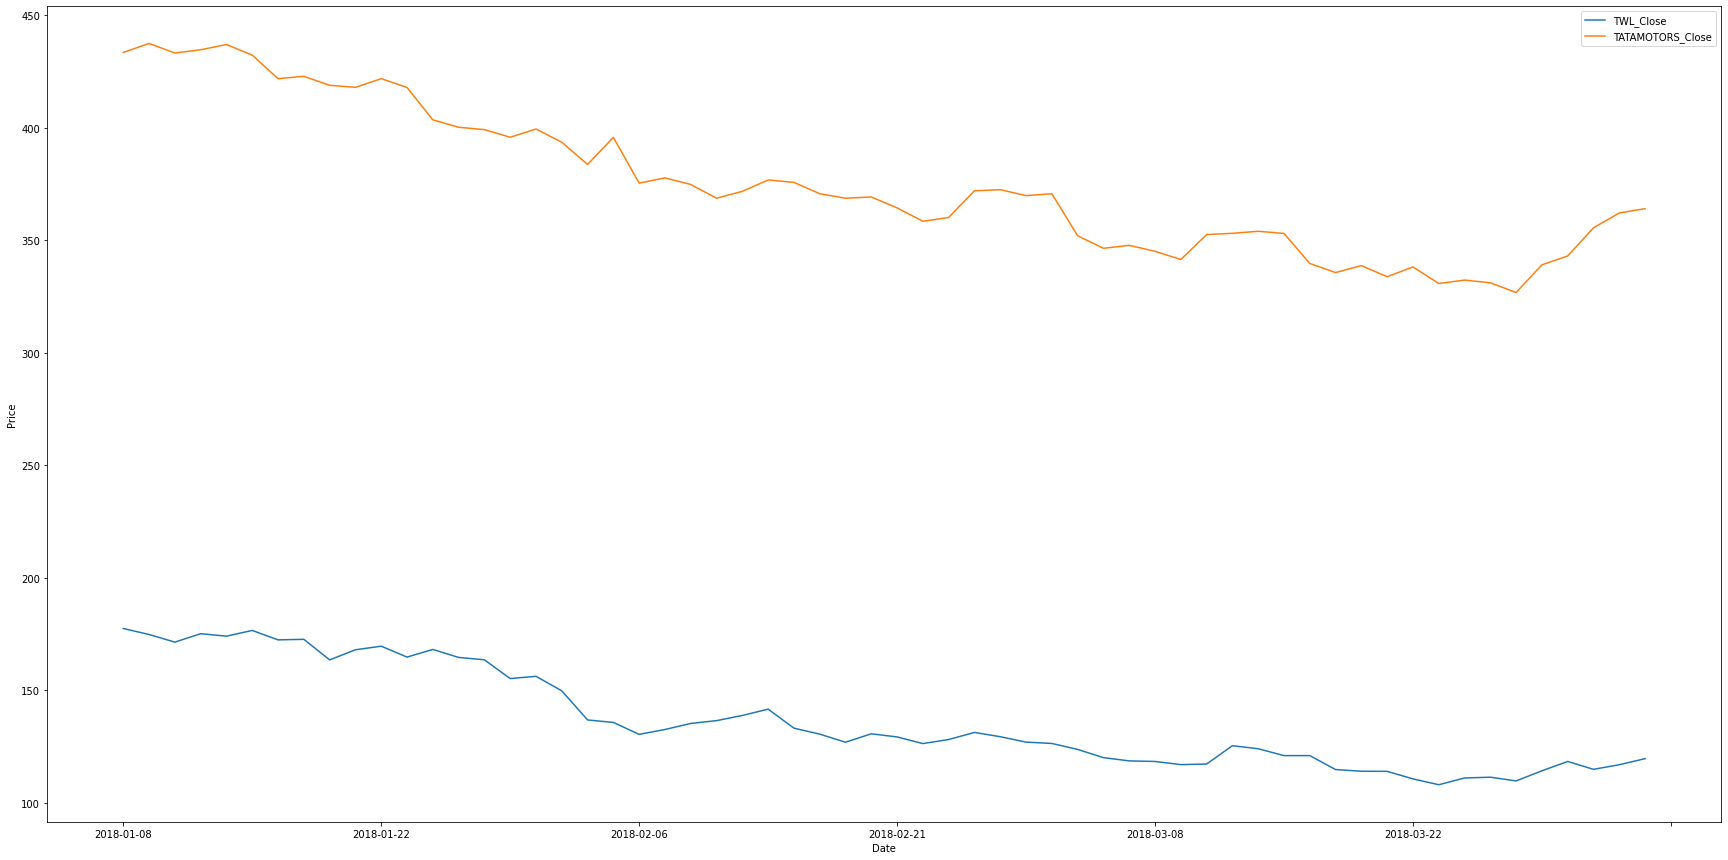

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TWL_Close', 'TATAMOTORS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TATAMOTORS Linear Regression Model

## 3.1. Get the Complete TATAMOTORS dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TATAMOTORSNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,488.700012,469.049988,472.000000,487.049988,4024156.0,487.049988,TATAMOTORS,NSE
1,2017-01-03,492.700012,479.899994,491.000000,481.100006,5814518.0,481.100006,TATAMOTORS,NSE
2,2017-01-04,493.700012,484.100006,484.649994,486.649994,4769872.0,486.649994,TATAMOTORS,NSE
3,2017-01-05,503.399994,495.549988,496.000000,502.149994,7961242.0,502.149994,TATAMOTORS,NSE
4,2017-01-06,507.950012,496.250000,502.950012,497.750000,4907475.0,497.750000,TATAMOTORS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TATAMOTORS training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,487.049988
1,2017-01-03,481.100006
2,2017-01-04,486.649994
3,2017-01-05,502.149994
4,2017-01-06,497.750000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,383.399994
167,2017-09-05,388.149994
168,2017-09-06,382.700012
169,2017-09-07,378.149994
170,2017-09-08,375.049988


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,261.700012
413,2018-08-30,259.350006
414,2018-08-31,267.500000
415,2018-09-03,266.600006
416,2018-09-04,261.950012


### 3.2.3 Get the training data and labels

In [10]:
tata_train = tata_df_train.copy()
tata_train

,Date,Close
166,2017-09-04,383.399994
167,2017-09-05,388.149994
168,2017-09-06,382.700012
169,2017-09-07,378.149994
170,2017-09-08,375.049988
...,...,...
412,2018-08-29,261.700012
413,2018-08-30,259.350006
414,2018-08-31,267.500000
415,2018-09-03,266.600006


In [11]:
tata_train = tata_train.reset_index(drop=True)
tata_train = tata_train['Close']
tata_train

0      383.399994
1      388.149994
2      382.700012
3      378.149994
4      375.049988
          ...    
246    261.700012
247    259.350006
248    267.500000
249    266.600006
250    261.950012
Name: Close, Length: 251, dtype: float64

In [12]:
len(tata_train)

251

## 3.3. Get TATAMOTORS Test Data

In [13]:
tata_test_df = orders_df.copy()
tata_test_df = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test_df.head()

,Date,Close
416,2018-09-04,261.950012
417,2018-09-05,266.500000
418,2018-09-06,269.950012
419,2018-09-07,277.399994
420,2018-09-10,275.700012


In [14]:
tata_test_df.tail()

,Date,Close
470,2018-11-27,180.050003
471,2018-11-28,174.449997
472,2018-11-29,177.250000
473,2018-11-30,171.949997
474,2018-12-03,175.449997


In [15]:
tata_test = tata_test_df.copy()
tata_test.reset_index(drop=True, inplace=True)
tata_test.index += 251
tata_test.head()

,Date,Close
251,2018-09-04,261.950012
252,2018-09-05,266.500000
253,2018-09-06,269.950012
254,2018-09-07,277.399994
255,2018-09-10,275.700012


In [16]:
tata_test.tail()

,Date,Close
305,2018-11-27,180.050003
306,2018-11-28,174.449997
307,2018-11-29,177.250000
308,2018-11-30,171.949997
309,2018-12-03,175.449997


In [17]:
tata_test = tata_test['Close']

In [18]:
len(tata_test)

59

## 3.4 Create and Train TATAMOTORS Model

In [19]:
model = auto_arima(tata_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(tata_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1730.775, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1685.788, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1732.192, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1671.147, Time=1.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1669.219, Time=0.89 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1683.788, Time=0.29 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1671.142, Time=1.52 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=11.12 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1671.137,

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(tata_test))
forecast = pd.DataFrame(forecast, index = tata_test.index, columns=['Prediction'])
forecast

,Prediction
251,263.351346
252,265.761722
253,265.536848
254,257.958445
255,256.235580
256,257.217947
257,260.215778
258,261.763943
259,258.218134
260,261.508583


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test, predictions)))

Mean Absolute Error: 60.0528845774463
Mean Squared Error: 4675.9449637828975
Root Mean Squared Error: 68.3808815662894


## 3.6. Visualize the predicitons vs test data

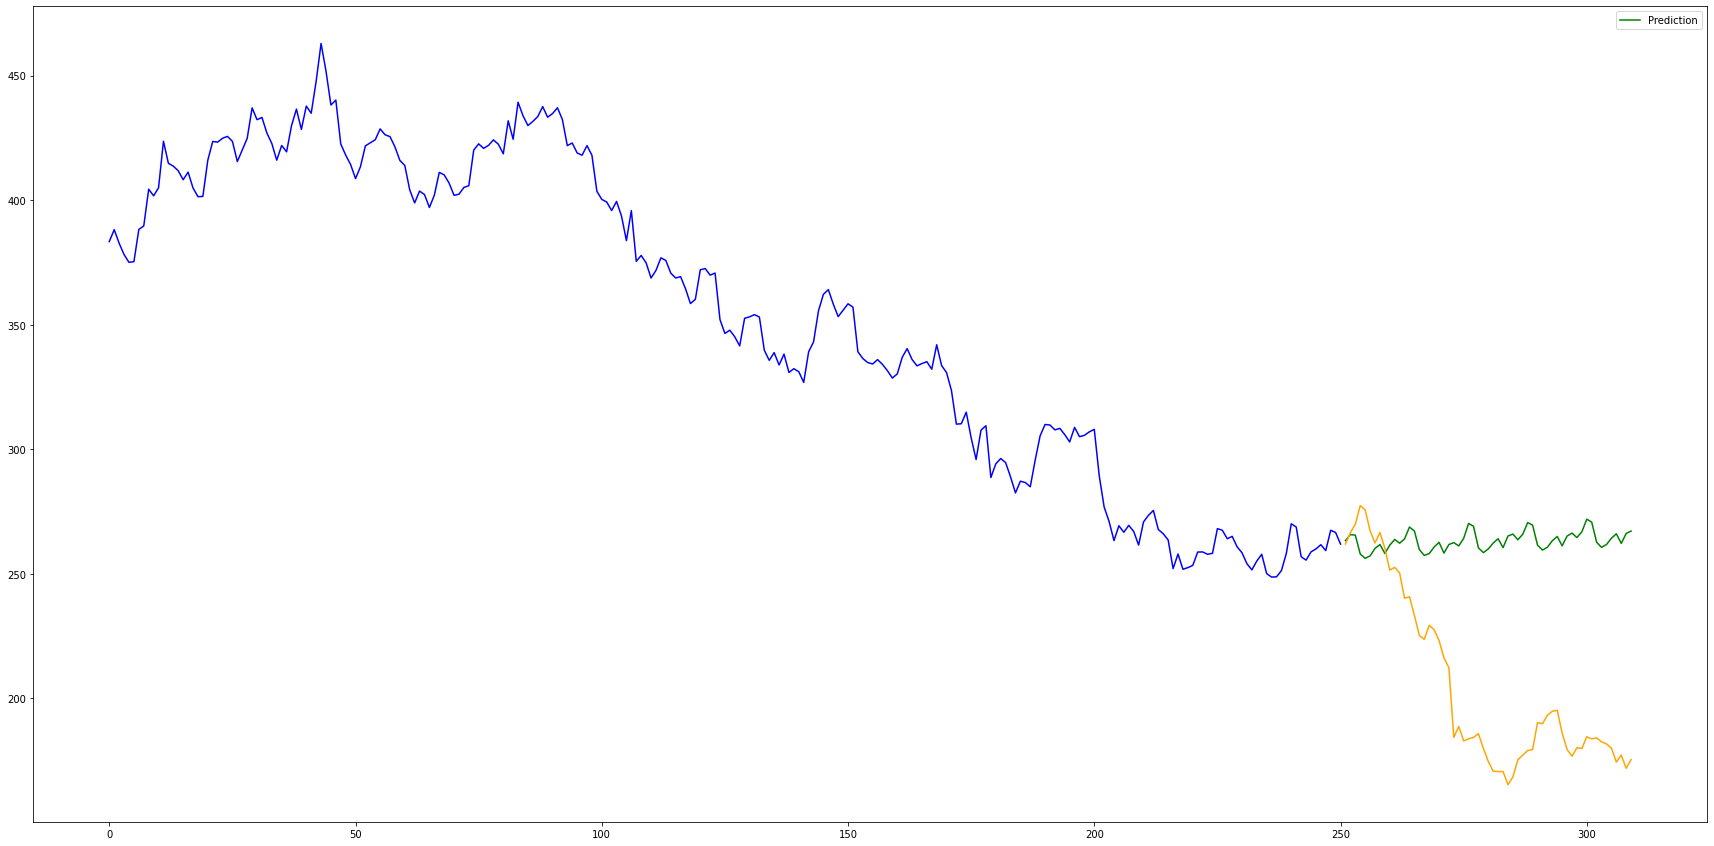

In [22]:
tata_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
tata_model_plt.plot(tata_train, c='blue')
tata_model_plt.plot(tata_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
tata_predictions_df = pd.read_csv('Tata_predicitions.csv')
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-01-08,433.549988,259.002342
1,2018-01-09,437.549988,258.402641
2,2018-01-10,433.299988,257.802941
3,2018-01-11,434.750000,257.203241
4,2018-01-12,437.100006,255.744917


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
tata_predictions_df['ARIMA_Close'] = forecast['Prediction']
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-01-08,433.549988,259.002342,263.351346
1,2018-01-09,437.549988,258.402641,265.761722
2,2018-01-10,433.299988,257.802941,265.536848
3,2018-01-11,434.750000,257.203241,257.958445
4,2018-01-12,437.100006,255.744917,256.235580


In [25]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)